In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from plotting_utils import *
#from ml_utils import *
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns;
import scipy
import os

matplotlib.rcParams['figure.dpi']= 150

colors = sns.color_palette("hls", n_colors=11)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


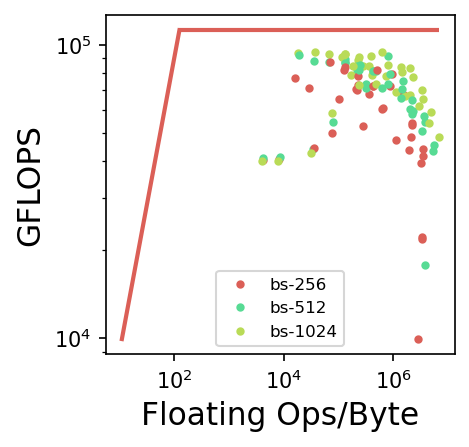

In [23]:
color_dim = 'bs'
d = get_data('v100_linear')


f, ax = plt.subplots(figsize=(3,3))
f, ax, m = plot_roofline(f, ax, d, tpu_peak=112e3, membdw_peak=900, color_dim=color_dim, title='')

# sort the legend
handles, ls = ax.get_legend_handles_labels()
ls = [int(i) for i in ls if i.isdigit()] 
ls, handles = zip(*sorted(zip(ls, handles), key=lambda t: t[0]))
ls = [color_dim + '-' + str(i) for i in ls]
ax.legend(handles, ls, frameon=True, fontsize=8)

## Ascend 910 Roofline

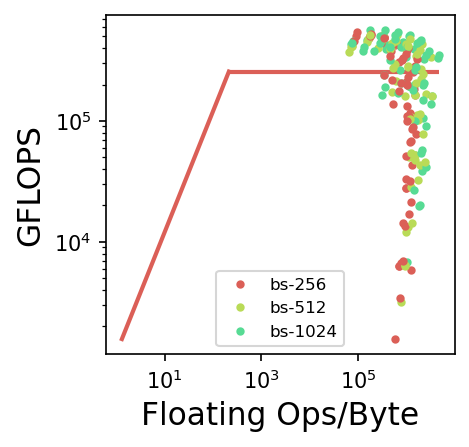

In [11]:
color_dim = 'bs'
d = get_data('ascend910_linear')


f, ax = plt.subplots(figsize=(3,3))
f, ax, m = plot_roofline(f, ax, d, tpu_peak=256e3, membdw_peak=1200, color_dim=color_dim, title='')

# sort the legend
handles, ls = ax.get_legend_handles_labels()
ls = [int(i) for i in ls if i.isdigit()] 
ls, handles = zip(*sorted(zip(ls, handles), key=lambda t: t[0]))
ls = [color_dim + '-' + str(i) for i in ls]
ax.legend(handles, ls, frameon=True, fontsize=8)

In [136]:
from data_utils import *

## Ascend 910 linear analysis

In [137]:
d_ascend910_linear = get_data('ascend910_linear')
peak_flops = 256e12

In [138]:
print(f"total data points:  {len(d_ascend910_linear['labels'])}")

total data points:  192


### max flops

In [139]:
max_index = np.argmax(d_ascend910_linear['flops'])
max_flops = d_ascend910_linear['flops'][max_index]
print(f"max flops {max_flops} FLOPS%: {max_flops/peak_flops}")
print(f"max flops with label {d_ascend910_linear['labels'][max_index]}")

max flops 220161240764370.4 FLOPS%: 0.8600048467358219
max flops with label bs_1024-input_32768-output_8192


### min flops

In [140]:
min_index = 0
min_flops = 256e12
for i in range(len(d_ascend910_linear['labels'])):
    if d_ascend910_linear['state'][i] == "fine" and d_ascend910_linear['flops'][i] < min_flops:
        min_index = i
        min_flops = d_ascend910_linear['flops'][i]
print(f"min flops {min_flops} FLOPS%: {min_flops/peak_flops}")
print(f"min flops with label {d_ascend910_linear['labels'][min_index]}")

min flops 1024797486058.0781 FLOPS%: 0.004003115179914368
min flops with label bs_256-input_512-output_512


['bs', '1024']
['input', '8192']
['output', '16384']
check x y [ 1.33630621 -0.38338149  0.00301875] 1.201865890767819


/home/u20200002/.conda/envs/torch1.5/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


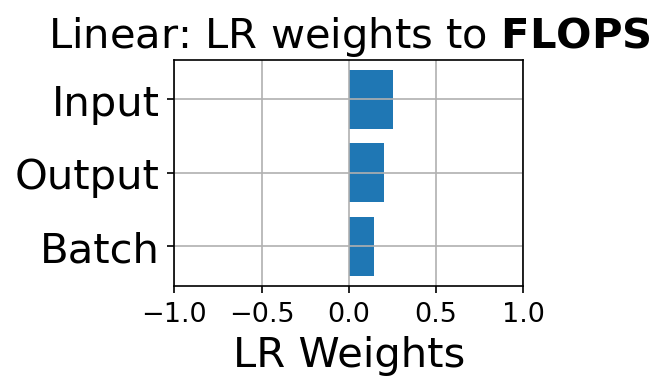

In [141]:
from ml_utils import *
f = regression(d_ascend910_linear['labels'], d_ascend910_linear['flops'],
               title = r'Linear: LR weights to $\bf{FLOPS}$')

In [116]:
d_v100_linear = get_data('v100_linear')

forward-float16-bs_256-input_1024-output_4096
forward-float16-bs_256-input_512-output_8192


length of speedups 183
max speedup: 5.753879772296254 label: forward-float16-bs_1024-input_65536-output_8192
min speedup: 0.20817712541743963 label: forward-float16-bs_512-input_512-output_512
bs [256, 512, 1024]
input [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
output [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
-----------------------


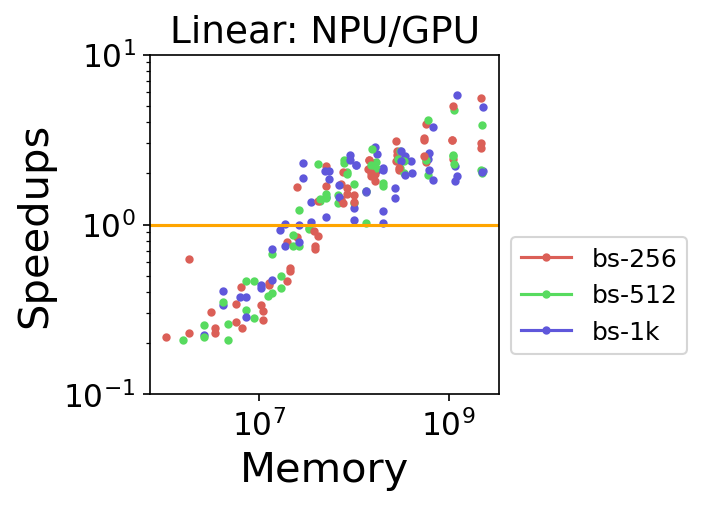

In [135]:
from plot_utils import *
f = speedup_params(d_ascend910_linear['labels'], d_ascend910_linear['example_per_sec'], 
               d_v100_linear['labels'], d_v100_linear['example_per_sec'], d_v100_linear['memory'],  marker='.', lim=[0.1, 10],
                   legend_box=(1,0.5),
               color='bs', title= 'Linear: NPU/GPU')

## Ascend 910 conv2d analysis

In [73]:
d_ascend910_conv2d = get_data('ascend910_conv2d')

In [74]:
print(f"total data points:  {len(d_ascend910_conv2d['labels'])}")

total data points:  367


### max flops

In [75]:
max_index = np.argmax(d_ascend910_conv2d['flops'])
max_flops = d_ascend910_conv2d['flops'][max_index]
print(f"max flops {max_flops} FLOPS%: {max_flops/peak_flops}")
print(f"max flops with label {d_ascend910_conv2d['labels'][max_index]}")

max flops 225145460571807.88 FLOPS%: 0.8794744553586246
max flops with label npu-forward-float16-bs_512-input_224-inchannel_32-outchannel_128-filtersize_7


In [76]:
min_index = 0
min_flops = 256e12
for i in range(len(d_ascend910_conv2d['labels'])):
    if d_ascend910_conv2d['state'][i] == "fine" and d_ascend910_conv2d['flops'][i] < min_flops:
        min_index = i
        min_flops = d_ascend910_conv2d['flops'][i]
print(f"min flops {min_flops} FLOPS%: {min_flops/peak_flops}")
print(f"min flops with label {d_ascend910_conv2d['labels'][min_index]}")

min flops 12597594582036.828 FLOPS%: 0.04920935383608136
min flops with label npu-forward-float16-bs_128-input_448-inchannels_32-outchannels_64-filtersize_1


### LR weights

['bs', '128']
['input', '224']
['inchannels', '32']
['outchannels', '128']
['filtersize', '7']
check x y [-1.07902794 -0.98110491 -1.03292424 -0.23267695  1.33945474] 2.8343406525376267


/home/u20200002/.conda/envs/torch1.5/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


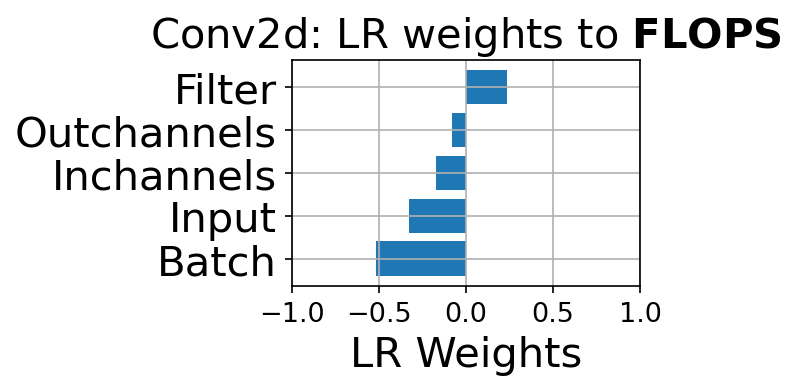

In [77]:
from ml_utils import *
f = regression(d_ascend910_conv2d['labels'], d_ascend910_conv2d['flops'],
               title = r'Conv2d: LR weights to $\bf{FLOPS}$')

In [94]:
states = np.array(d_ascend910_conv2d['state'])
labels = np.array(d_ascend910_conv2d['labels'])

103

In [99]:
is_error = np.where(states == 'error', 2, 0)

['bs', '128']
['input', '224']
['inchannels', '32']
['outchannels', '128']
['filtersize', '7']
0.7193460490463215


ValueError: too many values to unpack (expected 2)

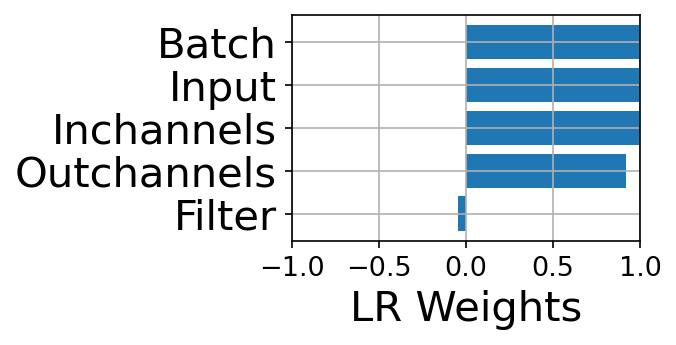

In [100]:
error_cls = classification(labels, is_error)